In [ ]:
!pip install umap-learn
!pip install opencv-python

In [ ]:
import os
import random

import numpy as np

import cv2

import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt

import sklearn.model_selection as skms
import sklearn.preprocessing as skp
import sklearn.utils as sku
import sklearn.decomposition as skd
import sklearn.metrics as skm

from sklearn.manifold import TSNE
from sklearn.model_selection import KFold

import umap.umap_ as umap

**Settings and unzip data**

In [ ]:
# GOOGLE COLAB
USE_GOOGLE_COLAB = True # Are you using Google Colab ?
COLAB_WORKING_PATH = "/content/drive/My Drive/Colab/Botanist" if USE_GOOGLE_COLAB else "."

# Mount on Google Drive
if USE_GOOGLE_COLAB:
  from google.colab import drive
  drive.mount('/content/drive/', force_remount=True)

# PATHS
DATASET_ZIP_PATH = f"{COLAB_WORKING_PATH}/herbier.zip" # Path to zipped data
DATASET_PATH = "/content/data/"  if USE_GOOGLE_COLAB else "./"


WORKDIR = f"{DATASET_PATH}herbier"
WORD_DATA_PATH = f"{WORKDIR}/data_public/words/"
METADATA_PATH = f"{WORKDIR}/data_public/ascii/words.txt"
#DATA_CROP_PATH = f"{DATASET_PATH}data_crop/"
DATA_CROP_PATH = "/content/drive/My Drive/Colab/Botanist/data_crop/"

INFERENCE_DATASET_PATH = f"{COLAB_WORKING_PATH}/data_crop/"

# Create our data folder, unzip the data
if USE_GOOGLE_COLAB:
  if not os.path.exists(WORKDIR):
    !mkdir -p $DATASET_PATH
    !unzip "$DATASET_ZIP_PATH" -d $DATASET_PATH

# CNN
IMAGE_HEIGHT = 50
IMAGE_WIDTH = 75
N_CLASSES = 2

# Choose random classes
all_dirs = os.listdir(WORD_DATA_PATH)
selected_top_dirs = random.sample(all_dirs, N_CLASSES)
sub_dirs = {top_dir: os.listdir(os.path.join(WORD_DATA_PATH, top_dir)) for top_dir in selected_top_dirs}
random_subdirs = {top_dir: random.choice(sub_dirs[top_dir]) for top_dir in selected_top_dirs}

CLASSES = list(random_subdirs.values())
print(f"Selected classes: {CLASSES}")

FLATTEN_LAYER_NAME = 'flattened'

DEBUG = True

Mounted at /content/drive/
Selected classes: ['m02-069', 'a06-124']


**Load data**

<ipython-input-88-3fcf6ba0aedc>:75: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_train, X_test, y_train, y_test = skms.train_test_split(np.array(images), np.array(labels), test_size=0.2, random_state=42)


Loaded 343 words.
  Writer ID: a06-124; image shape: (50, 104, 1)
  Writer ID: a06-124; image shape: (65, 81, 1)
  Writer ID: a06-124; image shape: (16, 11, 1)
  Writer ID: a06-124; image shape: (39, 176, 1)
  Writer ID: a06-124; image shape: (14, 14, 1)
number of writers:  4


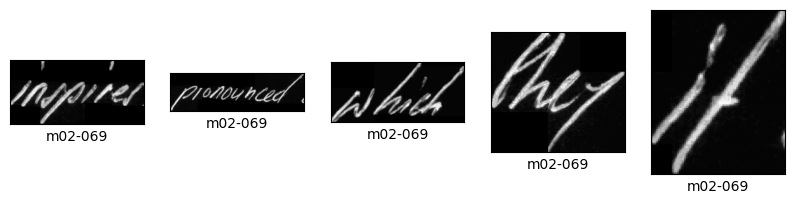

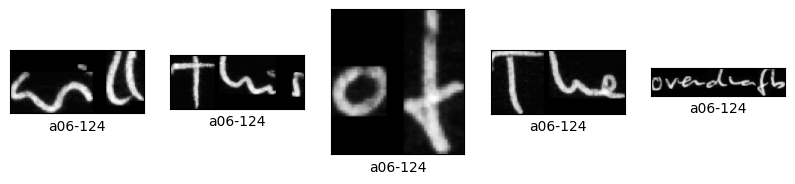

In [ ]:
def load_words_data(data_path, metadata_path, selected_writers = []):
    if selected_writers == []:
        raise ValueError("selected_writers must be a non-empty list of writer IDs")

    data = []

    with open(metadata_path, 'r') as file:
        for line in file:
            if not line.startswith("#"):
                components = line.strip().split(' ')
                word_id = components[0]

                parts = word_id.split('-')
                writer_id = '-'.join(parts[:2])

                if writer_id in selected_writers:
                    image_subfolder = parts[0]
                    image_filename = f"{word_id}.png"
                    image_path = os.path.join(data_path, image_subfolder, writer_id, image_filename)

                    if os.path.exists(image_path):
                        try:
                            img = tf.io.read_file(image_path)
                            img = tf.image.decode_png(img)
                            data.append({
                                'image_path': image_path,
                                'writer_id': writer_id,
                                'image_array': img
                            })
                        except tf.errors.InvalidArgumentError:
                            print(f"Image not found for word ID: {word_id} at {image_path}")
                    else:
                        print(f"Image not found for word ID: {word_id} at {image_path}")

    return data

def load_new_class_data(data_crop_path):
    new_class_data = []

    class_dirs = os.listdir(data_crop_path)

    # Select 2 random folders
    selected_dirs = random.sample(class_dirs, 2)

    for class_dir in selected_dirs:
        class_dir_path = os.path.join(data_crop_path, class_dir)
        image_files = os.listdir(class_dir_path)

        for image_file in image_files:
            image_path = os.path.join(class_dir_path, image_file)

            try:
                img = tf.io.read_file(image_path)
                img = tf.image.decode_png(img)
                new_class_data.append({
                    'image_path': image_path,
                    'writer_id': class_dir,  # Assuming folder name is the class name
                    'image_array': img
                })
            except tf.errors.InvalidArgumentError:
                print(f"Image not found for class {class_dir} at {image_path}")

    return new_class_data

words_data = load_words_data(WORD_DATA_PATH, METADATA_PATH, selected_writers=CLASSES)

new_classes_data = load_new_class_data(DATA_CROP_PATH)
words_data.extend(new_classes_data)

N_CLASSES = N_CLASSES + 2

images = [entry['image_array'] for entry in words_data]
labels = [entry['writer_id'] for entry in words_data]

X_train, X_test, y_train, y_test = skms.train_test_split(np.array(images), np.array(labels), test_size=0.2, random_state=42)


def plot_images(images, labels, num=5, class_num=N_CLASSES):
    plt.figure(figsize=(10,10))
    for i in range(num):
        plt.subplot(class_num,num,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(labels[i])
    plt.show()

def plot_random_samples(classes, num=5):
  for class_name in classes:
      class_indices = np.where(y_train == class_name)[0]
      size = min(num, len(class_indices))
      random_indices = np.random.choice(class_indices, size=size, replace=False)
      random_images = X_train[random_indices]
      plot_images(random_images, [class_name] * num)



if DEBUG:
  print(f"Loaded {len(words_data)} words.")
  for entry in words_data[:5]:
      print(f"  Writer ID: {entry['writer_id']}; image shape: {entry['image_array'].shape}")

  print("number of writers: ", len(set([entry['writer_id'] for entry in words_data])))

  plot_random_samples(CLASSES)

**Pre-processing**

X_train: (226, 50, 75, 1); y_train: (226,)
X_test: (57, 50, 75, 1); y_test: (57,)


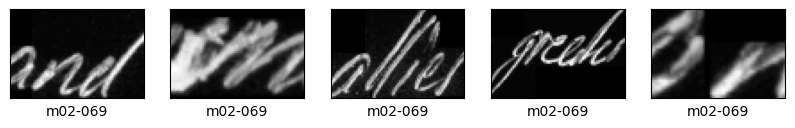

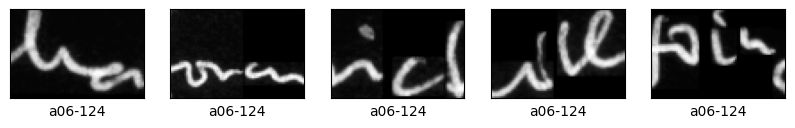

In [ ]:
def preprocess_data(data):
    labels = []
    images = []

    for entry in data:
        # Resize the image while preserving aspect ratio
        img = np.array(entry['image_array'])
        old_size = img.shape[:2]

        ratio = float(IMAGE_HEIGHT)/old_size[0]
        new_size = tuple([int(x*ratio) for x in old_size])

        img = cv2.resize(img, (new_size[1], new_size[0]))

        # Ignore images that are too narrows
        if new_size[1] < IMAGE_WIDTH:
          continue;

        # Crop images that are too wide
        if new_size[1] > IMAGE_WIDTH:
            start_x = (new_size[1] - IMAGE_WIDTH) // 2
            img = img[:, start_x:start_x + IMAGE_WIDTH]
            new_size = (new_size[0], IMAGE_WIDTH)

        img = img.astype('float32') / 255.0

        # Ensure dimensions format is correct: (sample_n, width, height, channels)
        img = np.expand_dims(img, axis=-1)
        delta_w = IMAGE_WIDTH - new_size[1]
        delta_h = IMAGE_HEIGHT - img.shape[0]
        delta_w = IMAGE_WIDTH - img.shape[1]
        padding = ((0, delta_h), (0, delta_w), (0, 0))
        img = np.pad(img, padding, 'constant')

        images.append(img)
        labels.append(entry['writer_id'])

    return np.array(images), np.array(labels)


images, labels = preprocess_data(words_data)
X_train, X_test, y_train, y_test = skms.train_test_split(images, labels, test_size=0.2, random_state=42)

if DEBUG:
  print(f"X_train: {X_train.shape}; y_train: {y_train.shape}")
  print(f"X_test: {X_test.shape}; y_test: {y_test.shape}")
  plot_random_samples(CLASSES)

In [ ]:
# data augmentation

data_generator = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=False,
    fill_mode='nearest'
)

**Kfold**

In [ ]:
# Define number of splits
n_splits = 5

# Create Kfold instance
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

**Set function to use kfold**

In [ ]:
def evaluate_model(n_neighbors, n_neighbors_list, min_dist, min_dist_list, class_labels, ax, features_standardized):
      reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=32, metric='euclidean')
      embedding = reducer.fit_transform(np.nan_to_num(features_standardized))

      sc = ax.scatter(embedding[:, 0], embedding[:, 1],
                      c=class_labels, edgecolor='none', alpha=0.5,
                      cmap=plt.cm.get_cmap('Accent', N_CLASSES))
      ax.set_xlabel('UMAP component 1')
      ax.set_ylabel('UMAP component 2')
      ax.set_title(f'n_neighbors={n_neighbors}, min_dist={min_dist}')

      if n_neighbors == n_neighbors_list[-1] and min_dist == min_dist_list[-1]:
          plt.colorbar(sc, ax=ax)

def train_and_evaluate(model, X_train, y_train, X_test, y_test):
  BATCH_SIZE = 5 # fine tuned
  EPOCHS = 30

  train_generator = data_generator.flow(X_train, y_train, batch_size=BATCH_SIZE)

  class_weights = sku.compute_class_weight(
      class_weight='balanced',
      classes=np.unique(integer_class_labels),
      y=integer_class_labels
  )
  class_weights_dict = {i : weight for i, weight in enumerate(class_weights)}

  early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
  history = model.fit(
      train_generator,
      epochs=EPOCHS,
      steps_per_epoch=len(X_train) // BATCH_SIZE,  # Number of batches per epoch
      validation_data=(X_test, y_test),
      class_weight=class_weights_dict,
      callbacks=[early_stopping]
  )

  ############

  feature_layer = model.get_layer(FLATTEN_LAYER_NAME).output

  # Create a feature extractor model
  feature_extractor_model = keras.models.Model(inputs=model.input, outputs=feature_layer)

  # Now you can use this model to extract features
  features = feature_extractor_model.predict(X_train)

  ############

  # features = model.predict(X_train)

  if DEBUG:
      print(f"features shape: {features.shape}")

  # Standardize the features
  scaler = skp.StandardScaler()
  features_standardized = scaler.fit_transform(features)

  # Now, use the standardized features with UMAP
  n_neighbors_list = [10, 20, 30]
  min_dist_list = [0.0, 0.1, 0.2]

  fig, axes = plt.subplots(len(n_neighbors_list), len(min_dist_list), figsize=(15, 12))

  axes = axes.flatten()

  for idx, (n_neighbors, min_dist) in enumerate([(x, y) for x in n_neighbors_list for y in min_dist_list]):
      evaluate_model(n_neighbors, n_neighbors_list, min_dist, min_dist_list, integer_class_labels, axes[idx], features_standardized)

  plt.tight_layout()
  plt.show()

**Define model**

In [ ]:
# Define modele
input_layer = keras.layers.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 1))

# Define L1 and L2 regularization
l1_l2 = keras.regularizers.l1_l2(l1=0, l2=1e-4)

# path 1
conv1_1 = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l1_l2)(input_layer)
pool1_1 = keras.layers.MaxPooling2D((2, 2))(conv1_1)
conv1_2 = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l1_l2)(pool1_1)
pool1_2 = keras.layers.MaxPooling2D((2, 2))(conv1_2)

# path 2
conv2_1 = keras.layers.Conv2D(32, (5, 5), activation='relu', padding='same', kernel_regularizer=l1_l2)(input_layer)
pool2_1 = keras.layers.MaxPooling2D((2, 2))(conv2_1)
conv2_2 = keras.layers.Conv2D(64, (5, 5), activation='relu', padding='same', kernel_regularizer=l1_l2)(pool2_1)
pool2_2 = keras.layers.MaxPooling2D((2, 2))(conv2_2)

# merge paths
merged = keras.layers.concatenate([pool1_2, pool2_2])

flat = keras.layers.Flatten()(merged)
dense1 = keras.layers.Dense(128, activation='relu', kernel_regularizer=l1_l2, name=FLATTEN_LAYER_NAME)(flat)
dropout = keras.layers.Dropout(0.2)(dense1)  # Consider experimenting with the dropout rate
output_layer = keras.layers.Dense(N_CLASSES, activation='softmax')(dropout)

model = keras.models.Model(inputs=input_layer, outputs=output_layer)

if DEBUG:
    model.summary()

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 50, 75, 1)]          0         []                            
                                                                                                  
 conv2d_20 (Conv2D)          (None, 50, 75, 32)           320       ['input_6[0][0]']             
                                                                                                  
 conv2d_22 (Conv2D)          (None, 50, 75, 32)           832       ['input_6[0][0]']             
                                                                                                  
 max_pooling2d_20 (MaxPooli  (None, 25, 37, 32)           0         ['conv2d_20[0][0]']           
 ng2D)                                                                                     

**Use kfold**


Fold 1 - Training set: X_train shape = (226, 50, 75, 1), y_train shape = (226, 4)
Fold 1 - Testing set: X_test shape = (57, 50, 75, 1), y_test shape = (57, 4)
Epoch 1/30
45/45 [==============================] - 4s 34ms/step - loss: 1.5960 - accuracy: 0.2760 - val_loss: 1.2368 - val_accuracy: 0.2632
Epoch 2/30
45/45 [==============================] - 0s 8ms/step - loss: 1.1548 - accuracy: 0.3937 - val_loss: 0.9467 - val_accuracy: 0.5439
Epoch 3/30
45/45 [==============================] - 0s 8ms/step - loss: 0.9325 - accuracy: 0.4887 - val_loss: 0.9021 - val_accuracy: 0.4912
Epoch 4/30
45/45 [==============================] - 0s 8ms/step - loss: 0.8490 - accuracy: 0.5023 - val_loss: 0.7515 - val_accuracy: 0.5965
Epoch 5/30
45/45 [==============================] - 0s 8ms/step - loss: 0.8269 - accuracy: 0.5068 - val_loss: 0.9829 - val_accuracy: 0.4386
Epoch 6/30
45/45 [==============================] - 0s 8ms/step - loss: 0.7931 - accuracy: 0.5385 - val_loss: 0.7449 - val_accuracy: 0.5439

<ipython-input-92-0a43c75603cf>:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('Accent', N_CLASSES))
<ipython-input-92-0a43c75603cf>:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('Accent', N_CLASSES))
<ipython-input-92-0a43c75603cf>:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('Accent', N_CLASSES))
<ipython-input-92-0a43c75603cf>:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matp

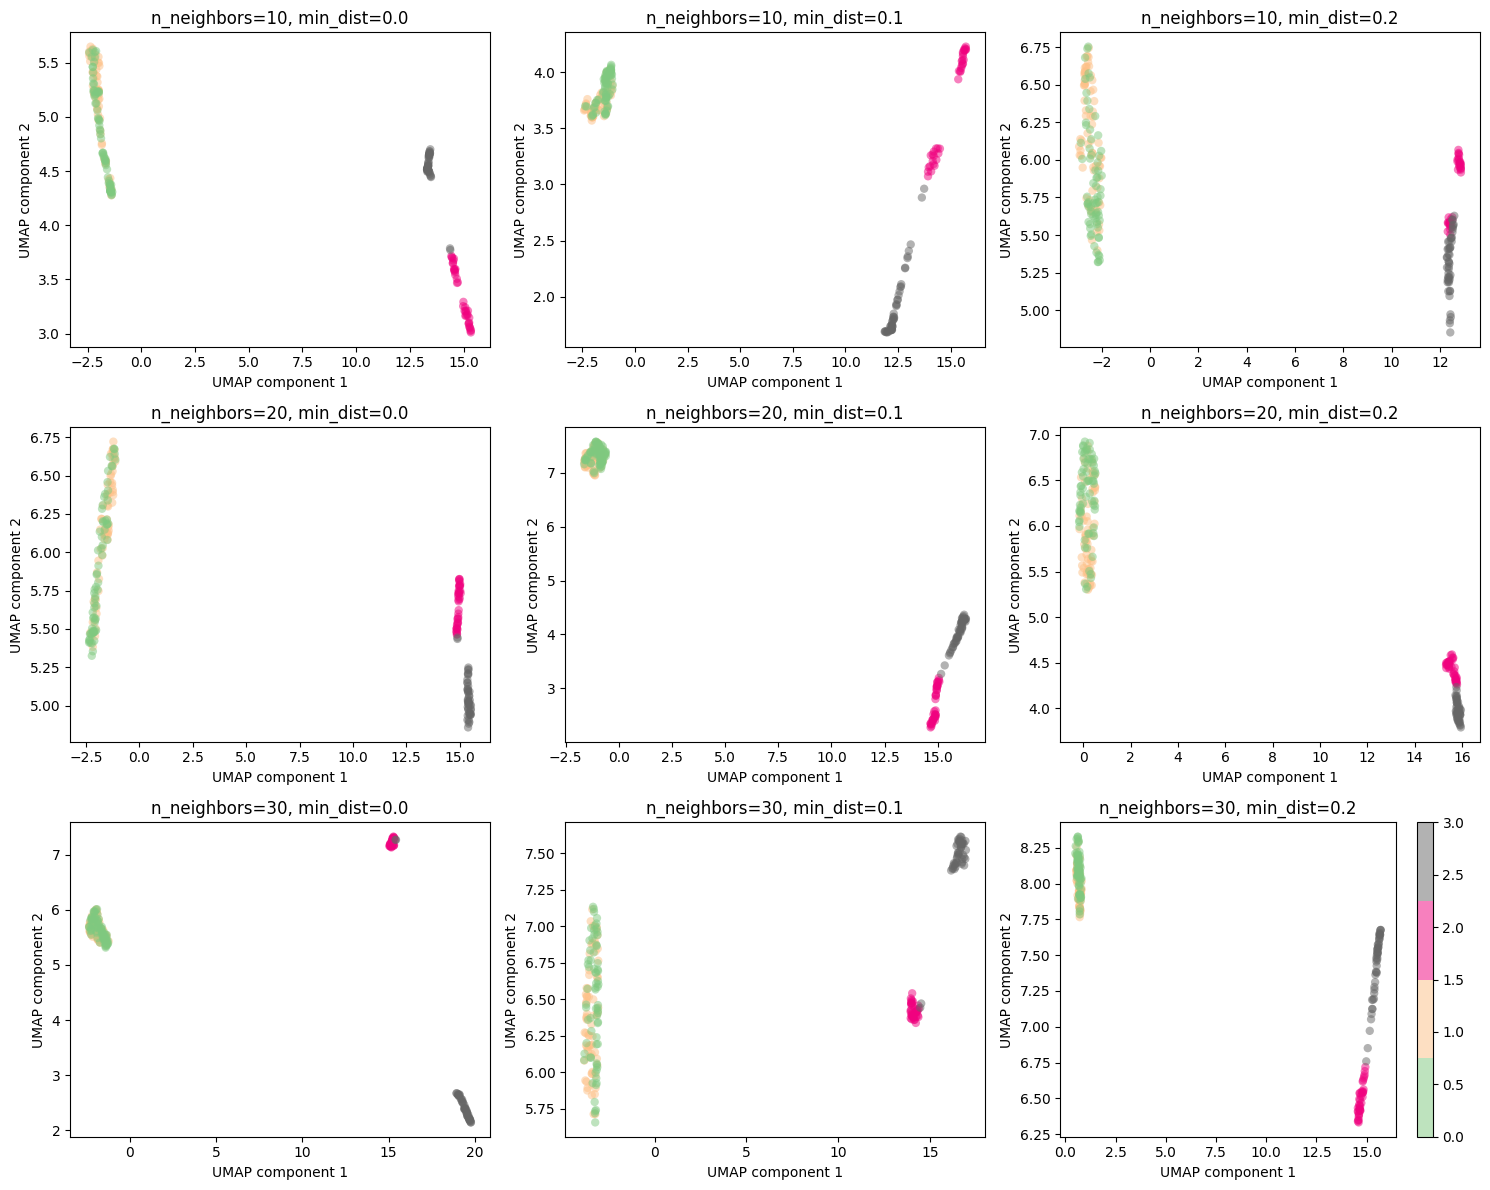


Fold 2 - Training set: X_train shape = (226, 50, 75, 1), y_train shape = (226, 4)
Fold 2 - Testing set: X_test shape = (57, 50, 75, 1), y_test shape = (57, 4)
Epoch 1/30
45/45 [==============================] - 0s 10ms/step - loss: 0.4387 - accuracy: 0.7466 - val_loss: 0.5012 - val_accuracy: 0.7193
Epoch 2/30
45/45 [==============================] - 0s 9ms/step - loss: 0.4415 - accuracy: 0.7511 - val_loss: 0.4416 - val_accuracy: 0.7895
Epoch 3/30
45/45 [==============================] - 0s 8ms/step - loss: 0.4194 - accuracy: 0.7421 - val_loss: 0.5308 - val_accuracy: 0.6667
Epoch 4/30
45/45 [==============================] - 0s 8ms/step - loss: 0.4230 - accuracy: 0.7964 - val_loss: 0.4941 - val_accuracy: 0.7018
Epoch 5/30
45/45 [==============================] - 0s 8ms/step - loss: 0.4199 - accuracy: 0.7466 - val_loss: 0.4462 - val_accuracy: 0.8070
Epoch 6/30
45/45 [==============================] - 0s 8ms/step - loss: 0.4486 - accuracy: 0.7059 - val_loss: 0.4666 - val_accuracy: 0.7895

<ipython-input-92-0a43c75603cf>:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('Accent', N_CLASSES))
<ipython-input-92-0a43c75603cf>:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('Accent', N_CLASSES))
<ipython-input-92-0a43c75603cf>:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('Accent', N_CLASSES))
<ipython-input-92-0a43c75603cf>:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matp

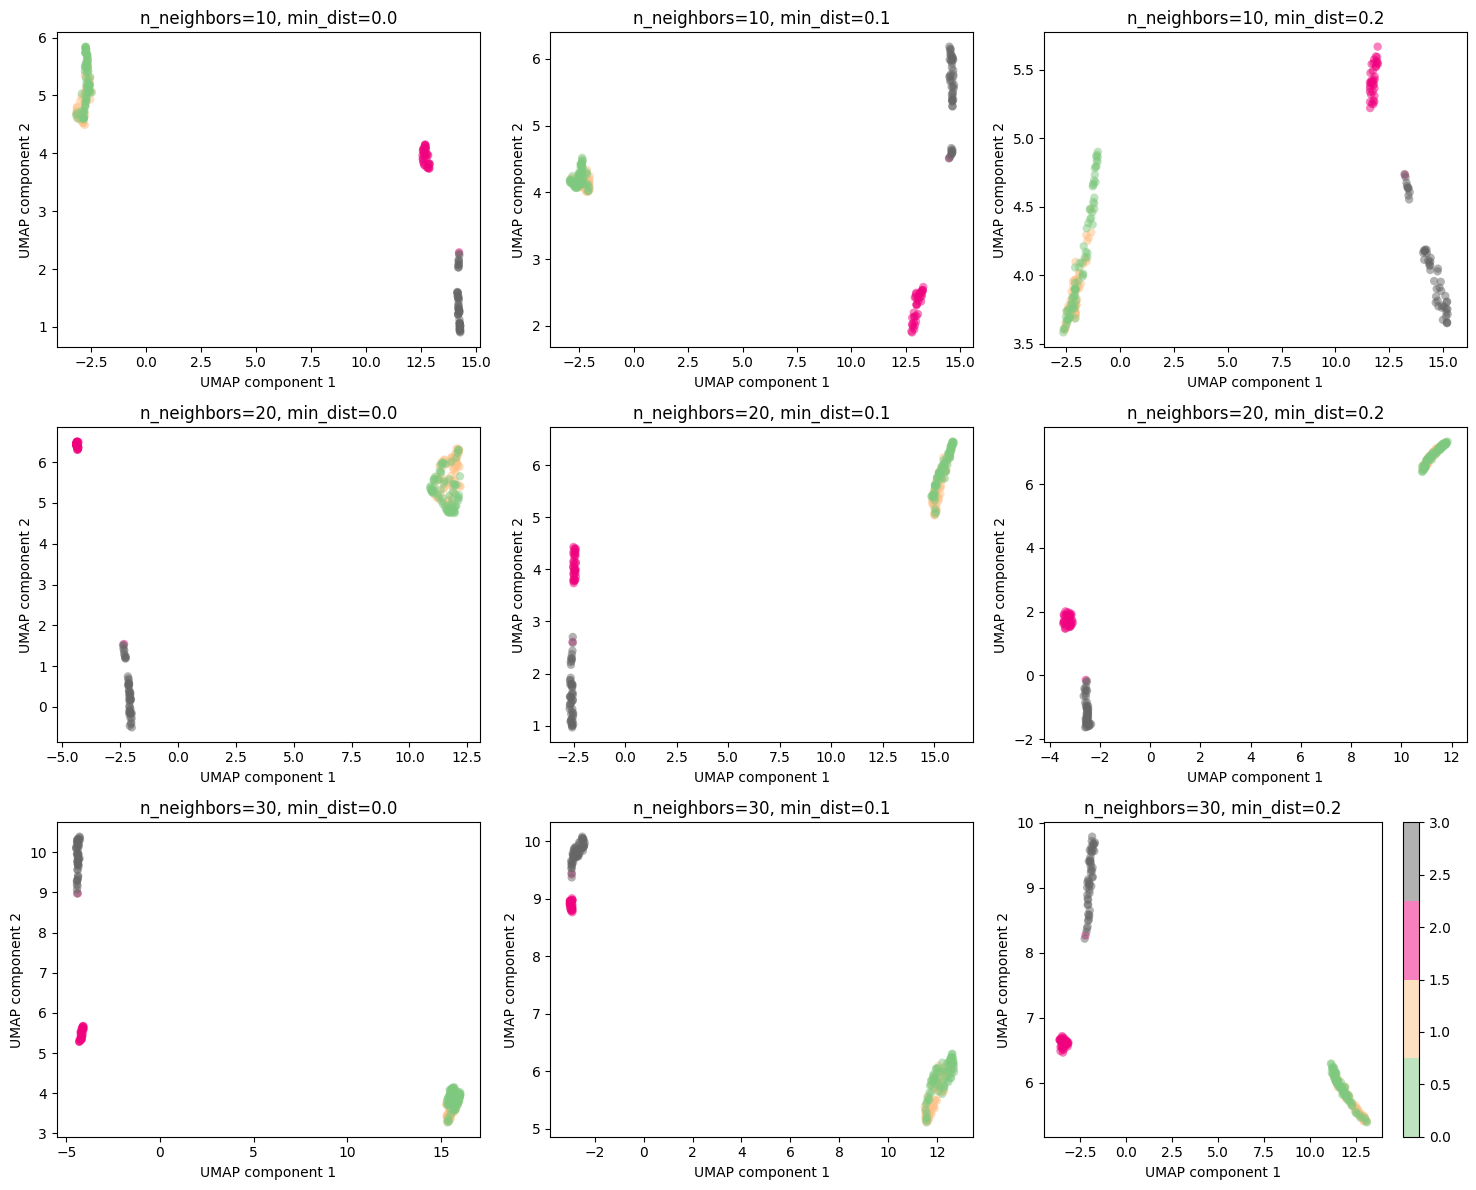


Fold 3 - Training set: X_train shape = (226, 50, 75, 1), y_train shape = (226, 4)
Fold 3 - Testing set: X_test shape = (57, 50, 75, 1), y_test shape = (57, 4)
Epoch 1/30
45/45 [==============================] - 0s 10ms/step - loss: 0.4180 - accuracy: 0.7738 - val_loss: 0.3904 - val_accuracy: 0.8246
Epoch 2/30
45/45 [==============================] - 0s 9ms/step - loss: 0.3916 - accuracy: 0.7783 - val_loss: 0.4402 - val_accuracy: 0.8070
Epoch 3/30
45/45 [==============================] - 0s 8ms/step - loss: 0.3755 - accuracy: 0.7919 - val_loss: 0.3830 - val_accuracy: 0.8421
Epoch 4/30
45/45 [==============================] - 0s 8ms/step - loss: 0.3785 - accuracy: 0.7873 - val_loss: 0.4227 - val_accuracy: 0.7544
Epoch 5/30
45/45 [==============================] - 1s 11ms/step - loss: 0.4869 - accuracy: 0.7557 - val_loss: 0.4337 - val_accuracy: 0.8596
Epoch 6/30
45/45 [==============================] - 1s 13ms/step - loss: 0.3945 - accuracy: 0.7602 - val_loss: 0.4339 - val_accuracy: 0.73

<ipython-input-92-0a43c75603cf>:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('Accent', N_CLASSES))
<ipython-input-92-0a43c75603cf>:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('Accent', N_CLASSES))
<ipython-input-92-0a43c75603cf>:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('Accent', N_CLASSES))
<ipython-input-92-0a43c75603cf>:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matp

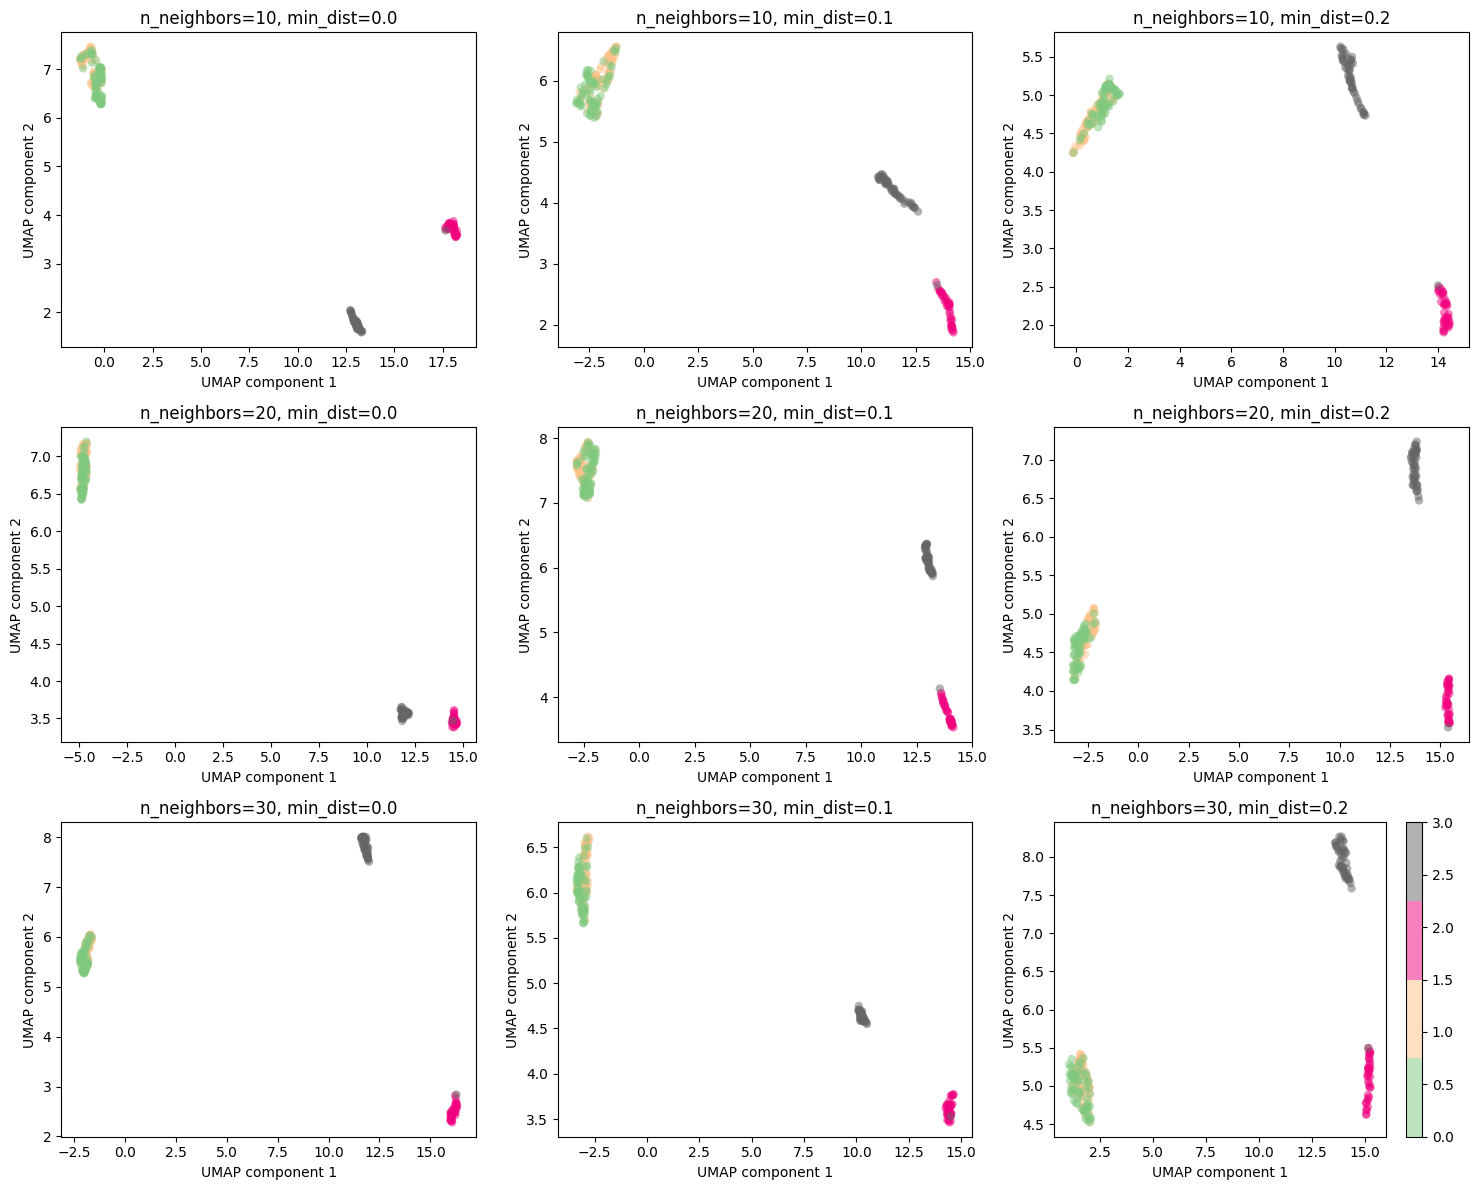


Fold 4 - Training set: X_train shape = (227, 50, 75, 1), y_train shape = (227, 4)
Fold 4 - Testing set: X_test shape = (56, 50, 75, 1), y_test shape = (56, 4)
Epoch 1/30
45/45 [==============================] - 1s 15ms/step - loss: 0.3531 - accuracy: 0.8153 - val_loss: 0.4302 - val_accuracy: 0.8036
Epoch 2/30
45/45 [==============================] - 1s 13ms/step - loss: 0.5157 - accuracy: 0.7387 - val_loss: 0.4236 - val_accuracy: 0.8214
Epoch 3/30
45/45 [==============================] - 0s 10ms/step - loss: 0.3726 - accuracy: 0.7928 - val_loss: 0.4396 - val_accuracy: 0.8036
Epoch 4/30
45/45 [==============================] - 0s 8ms/step - loss: 0.3622 - accuracy: 0.8018 - val_loss: 0.4505 - val_accuracy: 0.7857
Epoch 5/30
45/45 [==============================] - 0s 9ms/step - loss: 0.3901 - accuracy: 0.7658 - val_loss: 0.4280 - val_accuracy: 0.7857
Epoch 6/30
45/45 [==============================] - 0s 9ms/step - loss: 0.3649 - accuracy: 0.8108 - val_loss: 0.3976 - val_accuracy: 0.76

<ipython-input-92-0a43c75603cf>:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('Accent', N_CLASSES))
<ipython-input-92-0a43c75603cf>:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('Accent', N_CLASSES))
<ipython-input-92-0a43c75603cf>:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('Accent', N_CLASSES))
<ipython-input-92-0a43c75603cf>:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matp

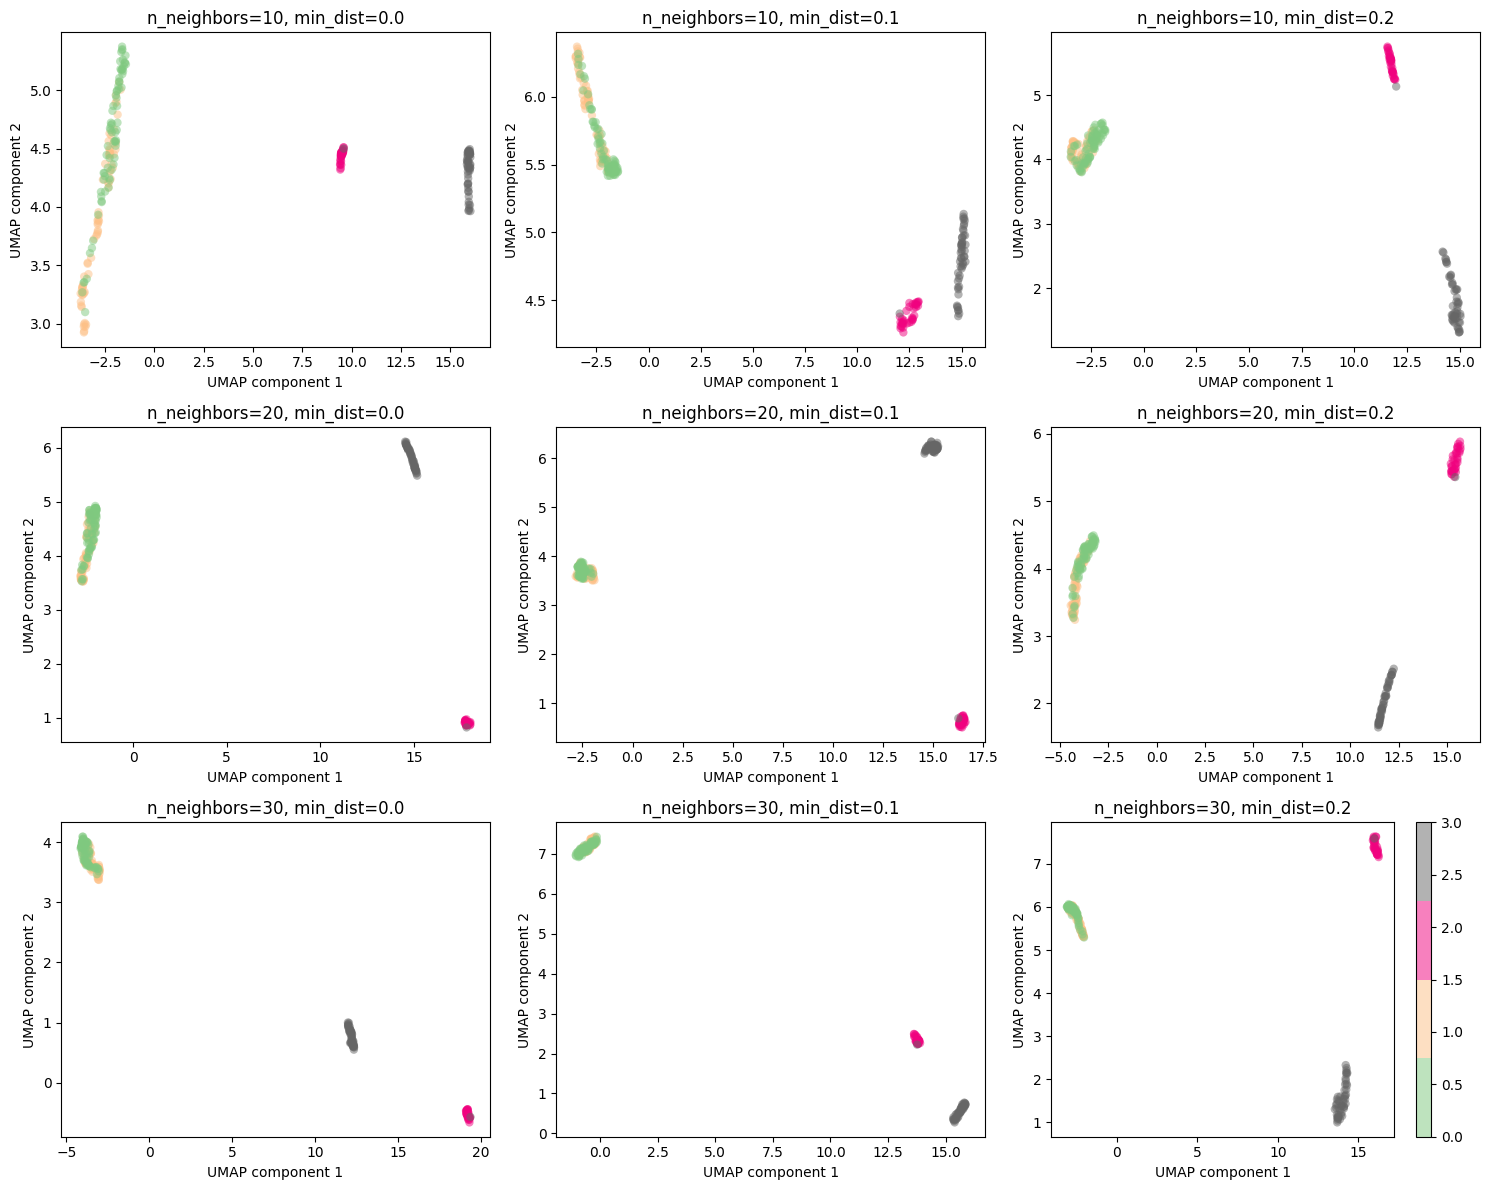


Fold 5 - Training set: X_train shape = (227, 50, 75, 1), y_train shape = (227, 4)
Fold 5 - Testing set: X_test shape = (56, 50, 75, 1), y_test shape = (56, 4)
Epoch 1/30
45/45 [==============================] - 0s 10ms/step - loss: 0.3830 - accuracy: 0.8063 - val_loss: 0.4281 - val_accuracy: 0.7857
Epoch 2/30
45/45 [==============================] - 0s 9ms/step - loss: 0.3694 - accuracy: 0.7748 - val_loss: 0.4284 - val_accuracy: 0.7321
Epoch 3/30
45/45 [==============================] - 0s 9ms/step - loss: 0.3920 - accuracy: 0.7793 - val_loss: 0.4497 - val_accuracy: 0.7857
Epoch 4/30
45/45 [==============================] - 0s 9ms/step - loss: 0.3735 - accuracy: 0.7928 - val_loss: 0.6021 - val_accuracy: 0.6607
Epoch 5/30
45/45 [==============================] - 0s 9ms/step - loss: 0.4066 - accuracy: 0.7883 - val_loss: 0.4657 - val_accuracy: 0.6964
Epoch 6/30
45/45 [==============================] - 0s 8ms/step - loss: 0.3380 - accuracy: 0.8243 - val_loss: 0.4500 - val_accuracy: 0.7857

<ipython-input-92-0a43c75603cf>:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('Accent', N_CLASSES))
<ipython-input-92-0a43c75603cf>:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('Accent', N_CLASSES))
<ipython-input-92-0a43c75603cf>:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('Accent', N_CLASSES))
<ipython-input-92-0a43c75603cf>:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matp

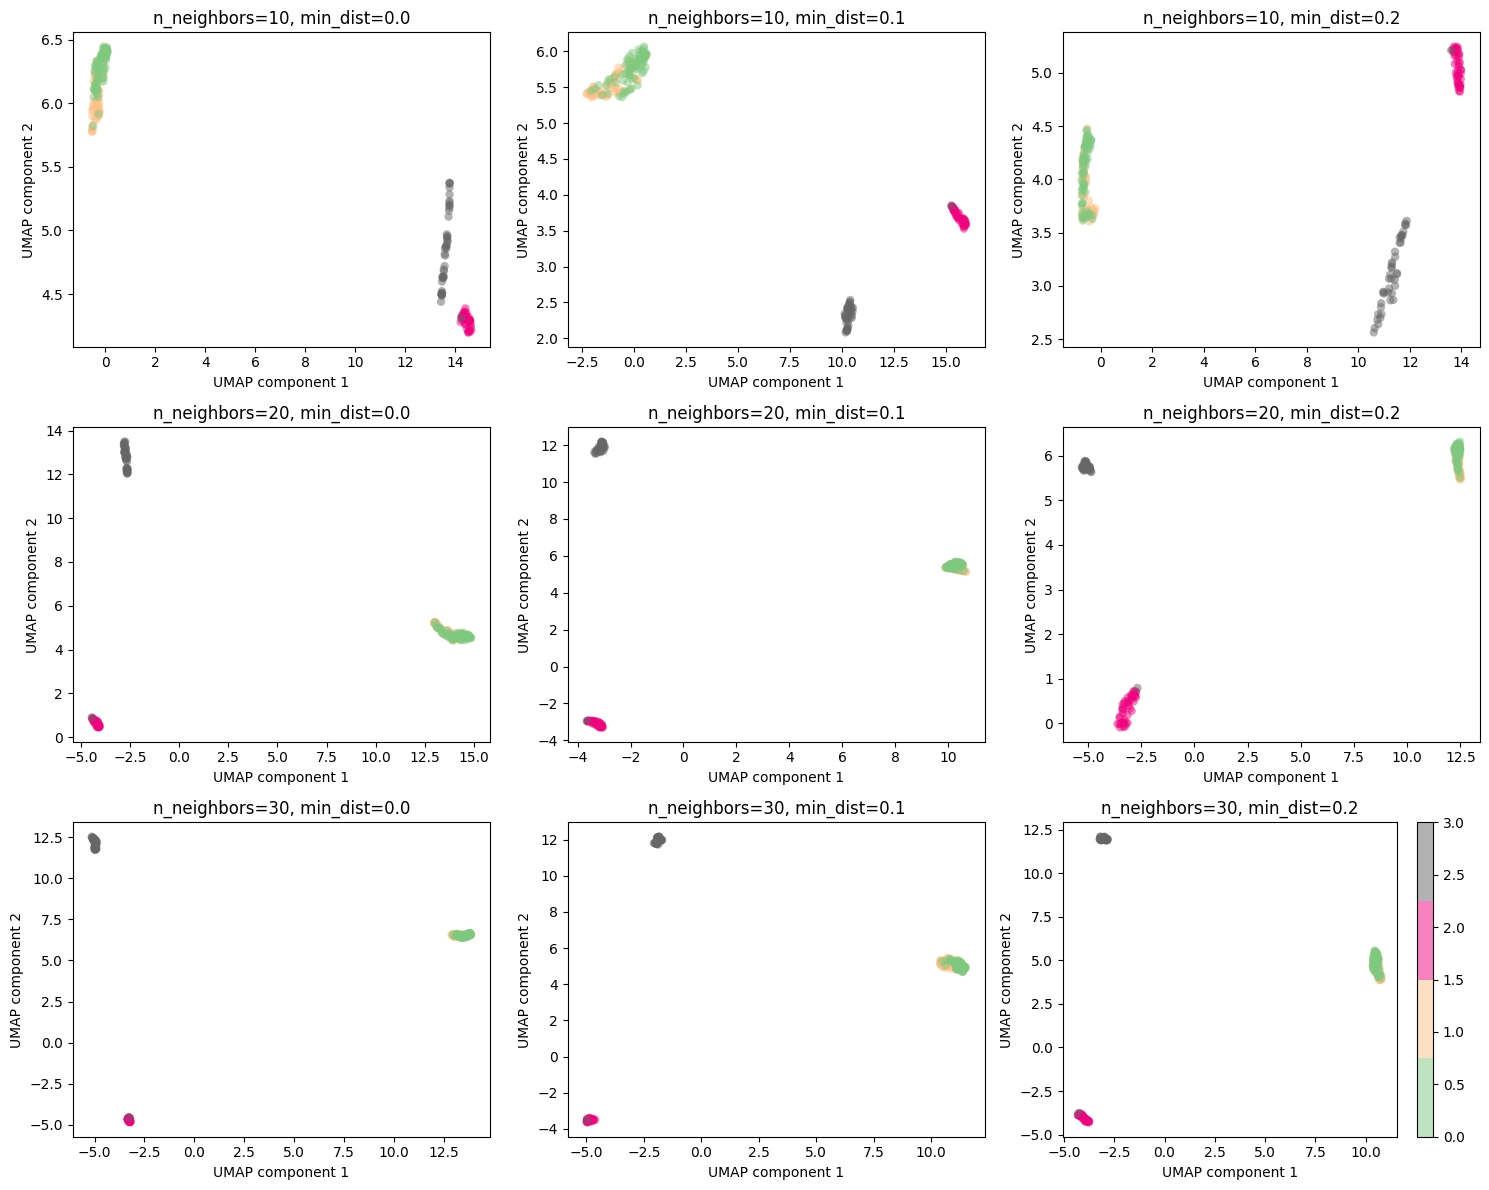

In [ ]:
# Execute kfold
for fold, (train_index, test_index) in enumerate(kf.split(images), 1):

    # encode labels
    label_encoder = skp.LabelEncoder()
    integer_encoded_labels = label_encoder.fit_transform(labels)
    one_hot_encoded_labels = keras.utils.to_categorical(integer_encoded_labels)

    X_train, X_test = images[train_index], images[test_index]
    y_train, y_test = one_hot_encoded_labels[train_index], one_hot_encoded_labels[test_index]

    print(f"\nFold {fold} - Training set: X_train shape = {X_train.shape}, y_train shape = {y_train.shape}")
    print(f"Fold {fold} - Testing set: X_test shape = {X_test.shape}, y_test shape = {y_test.shape}")

    integer_class_labels = np.argmax(y_train, axis=1)

    # Train and test modele
    train_and_evaluate(model, X_train, y_train, X_test, y_test)

**Inference**

Selected classes : ['Schleicher', 'Chaillet']
5/5 [==============================] - 0s 4ms/step
features shape: (160, 128)


<ipython-input-98-b4b0b6a33690>:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('Accent', N_CLASSES))
<ipython-input-98-b4b0b6a33690>:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('Accent', N_CLASSES))
<ipython-input-98-b4b0b6a33690>:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('Accent', N_CLASSES))
<ipython-input-98-b4b0b6a33690>:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matp

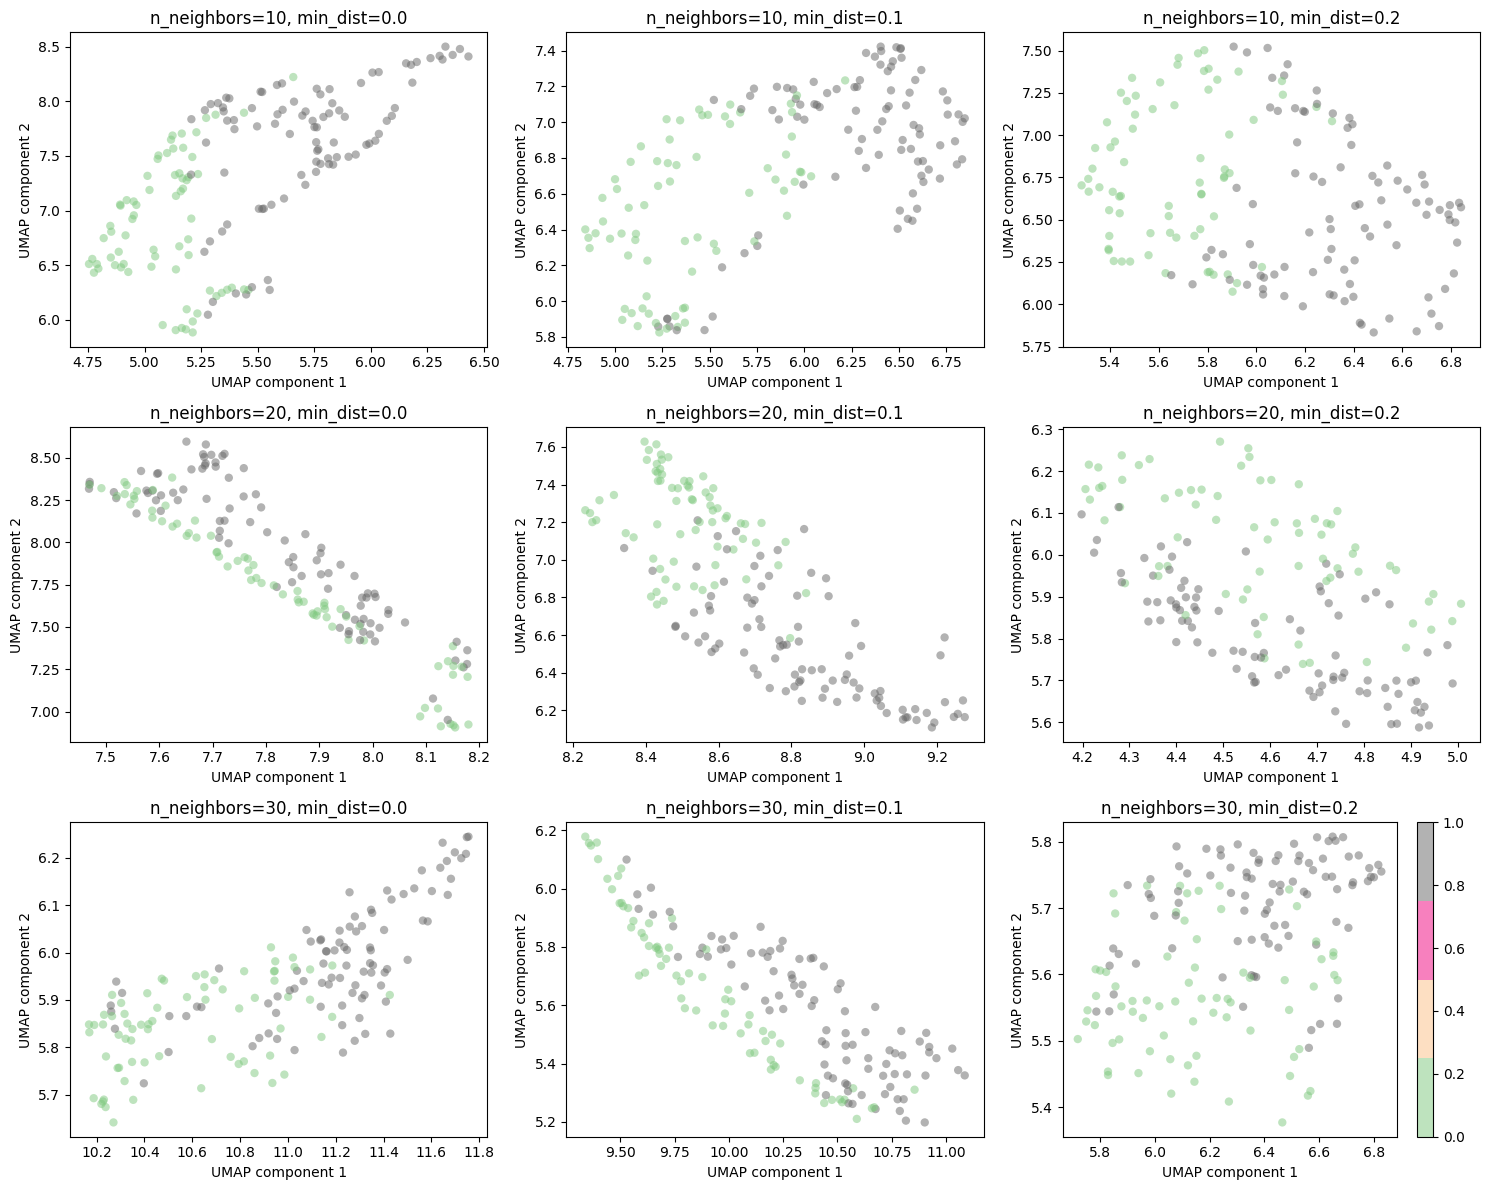

In [ ]:
from PIL import Image
from sklearn.preprocessing import LabelEncoder

dataset_path = DATA_CROP_PATH

data = []
class_dirs = os.listdir(dataset_path)

# Select 2 random folders
selected_dirs = random.sample(class_dirs, 2)

print("Selected classes :", selected_dirs)

# Fetch dataset image
for class_dir in selected_dirs:
    class_dir_path = os.path.join(dataset_path, class_dir)

    image_files = os.listdir(class_dir_path)
    for image_file in image_files:
        image_path = os.path.join(class_dir_path, image_file)

        image = Image.open(image_path)
        image_array = np.array(image)

        entry = {'image_array': image_array, 'writer_id': class_dir}
        data.append(entry)


# Prepare data
images, labels = preprocess_data(data)

le = LabelEncoder()
labels = le.fit_transform(labels)

X = np.array(images)
y = np.array(labels)

# Prediction
predictions = model.predict(X)

predicted_class_labels = np.argmax(predictions, axis=1)
true_class_labels = y

##############################

# Feature extraction and UMAP
feature_layer = model.get_layer(FLATTEN_LAYER_NAME).output

# Create a feature extractor model
feature_extractor_model = keras.models.Model(inputs=model.input, outputs=feature_layer)

# Now you can use this model to extract features
features = feature_extractor_model.predict(X)

if DEBUG:
    print(f"features shape: {features.shape}")

# Standardize the features
scaler = skp.StandardScaler()
features_standardized = scaler.fit_transform(features)

# Now, use the standardized features with UMAP
n_neighbors_list = [10, 20, 30]
min_dist_list = [0.0, 0.1, 0.2]

fig, axes = plt.subplots(len(n_neighbors_list), len(min_dist_list), figsize=(15, 12))

axes = axes.flatten()

for idx, (n_neighbors, min_dist) in enumerate([(x, y) for x in n_neighbors_list for y in min_dist_list]):
    evaluate_model(n_neighbors, n_neighbors_list, min_dist, min_dist_list, predicted_class_labels, axes[idx], features_standardized)

plt.tight_layout()
plt.show()

**Model evaluation**

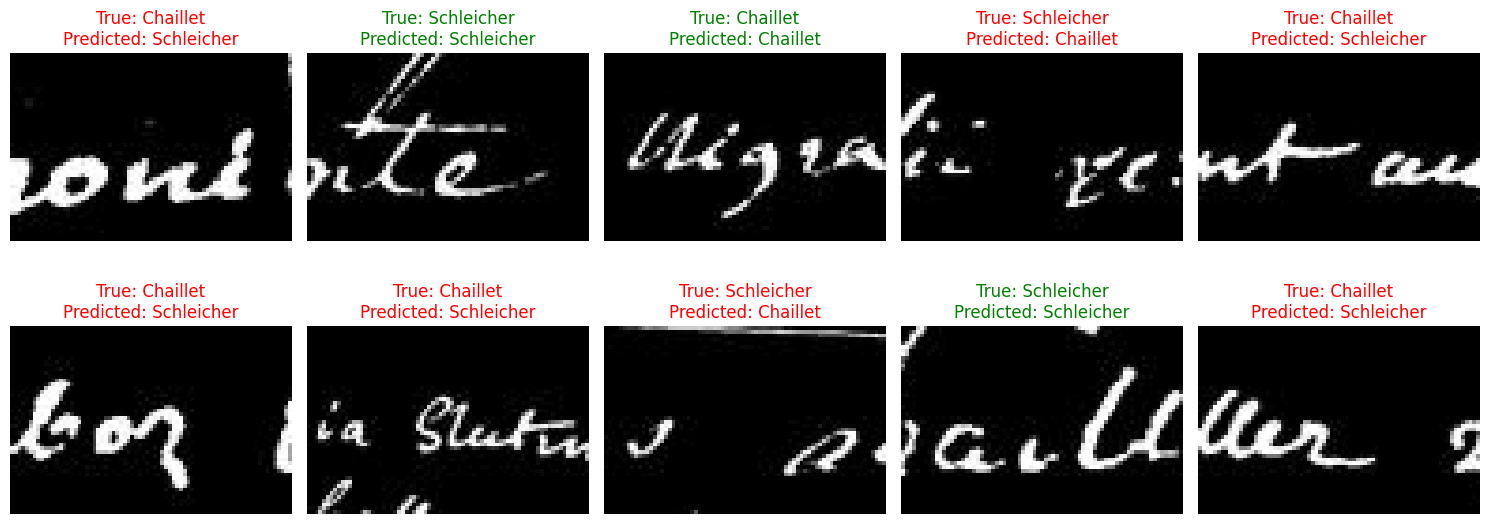

In [ ]:
# Plot 10 random images and their corresponding labels
indices = np.random.choice(range(len(X)), size=10, replace=False)

fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i, idx in enumerate(indices):
    ax = axes[i//5, i%5]

    ax.imshow(X[idx], cmap=plt.cm.binary)

    true_label = le.inverse_transform([y[idx]])[0]
    predicted_label = le.inverse_transform([predicted_class_labels[idx]])[0]
    title_color = 'green' if true_label == predicted_label else 'red'

    ax.set_title(f"True: {true_label}\nPredicted: {predicted_label}", color=title_color)
    ax.axis('off')

plt.tight_layout()
plt.show()

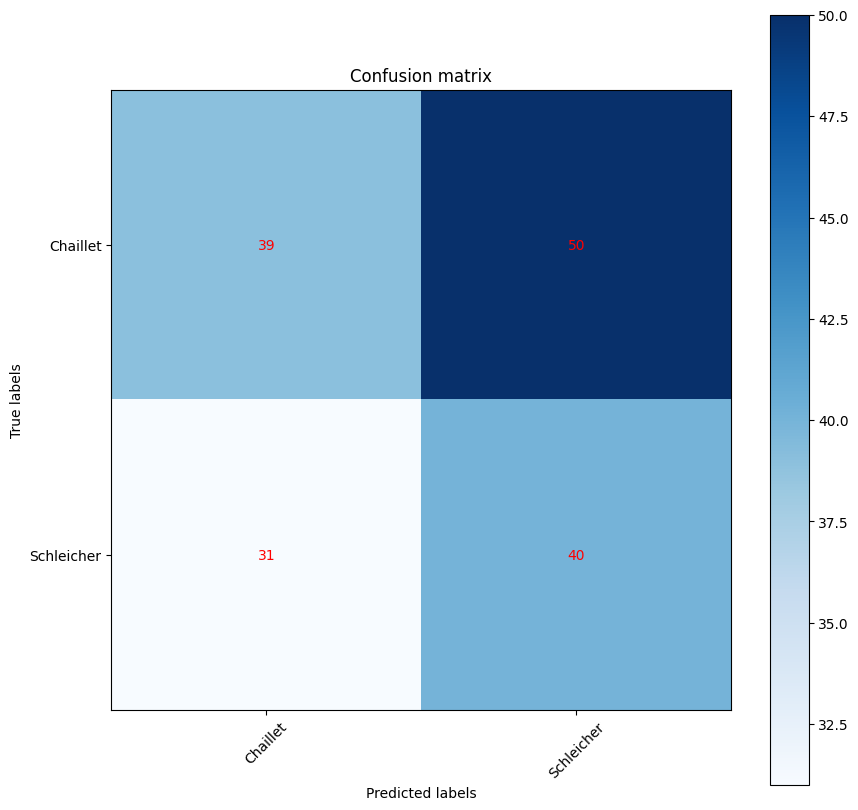

Precision: 0.5071
Recall: 0.4938
F1 score: 0.4934


In [ ]:
# Confusion matrix
confusion_matrix = skm.confusion_matrix(true_class_labels, predicted_class_labels)

plt.figure(figsize=(10, 10))
plt.imshow(confusion_matrix, cmap=plt.cm.Blues)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')

# Ajouter les labels aux axes x et y
class_names = le.classes_  # Récupérer les noms de classe à partir de l'encodeur
tick_marks = np.arange(len(class_names))

plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

# Titre de la matrice de confusion
plt.title('Confusion matrix')

plt.colorbar()

for i in range(confusion_matrix.shape[0]):
    for j in range(confusion_matrix.shape[1]):
        plt.text(j, i, confusion_matrix[i, j], ha='center', va='center', color='red')

plt.show()

# Precision, recall, F1 score
precision = skm.precision_score(true_class_labels, predicted_class_labels, average='weighted')
recall = skm.recall_score(true_class_labels, predicted_class_labels, average='weighted')
f1_score = skm.f1_score(true_class_labels, predicted_class_labels, average='weighted')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 score: {f1_score:.4f}")